In [1]:
import dm_event
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize

from scipy.interpolate import CubicSpline

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams.update({'font.size': 20})
#from importlib import reload
#reload(dm_event)

import pandas as pd
import ROOT as r
from root_numpy import tree2array

Welcome to JupyROOT 6.22/07


In [2]:
from differential_rate_electronDM import * 

In [3]:
_dRdE = dRdE

def rate_dme(Ebin, sigma, mchi, material, precompute_ims=True):
    """Differential event rate in events/(eV*kg*year) in bins of size Ebin.
    
    Parameters
    ----------
    Ebin: float
        Bin size in eV

    sigma: float
         Cross section in cm**2
    mchi: float
         DM mass in MeV
    material: string
        Material of the target (Si and Ge implemented)
         
    Return
    ----------
    Differential event rate in units of events/(ev*kg*year)
    """
    Eunits = 0.1
    band_gap = 1.11
    # calculate number of bins of size Ebin
    numbins = int(np.floor(nE*Eunits/Ebin))
    binlist = [band_gap+ii*Ebin for ii in range(numbins)]
    tmpEbin = int(np.floor(Ebin/Eunits))
    tmpdRdE = np.zeros(tmpEbin)
    array_ = np.zeros(numbins)
    for ne in range(numbins-1):
        for i in range(tmpEbin):
            energy = ne*Ebin+Eunits*i+band_gap
            tmpdRdE[i] = sigma*_dRdE(material, mchi, energy, 0,"shm", [230e5,240e5,600e5])
        array_[ne] = np.sum(tmpdRdE, axis = 0)
 
    return np.array(binlist), array_#/Ebin




In [52]:
f = r.TFile("dR_1e-37_10MeV_dmSKImg_clustersRec.root", "READ")

E = []
E_or = []

for i in f.clustersRec:
    #E += i.Energy*1000/3.77
    #print(i.pixels_E)
    #E_b = np.array(i.pixels_E[0])*1000/3.77
    E.extend(i.pixels_E[0])
    E_or.extend(i.Energy_MCT)


#E = tree2array(f.clustersRec, branches=["pixels_E"])
#E = f.clustersRec.AsMatrix(["Energy"])
#E = np.concatenate([np.asarray(e) for e in E])


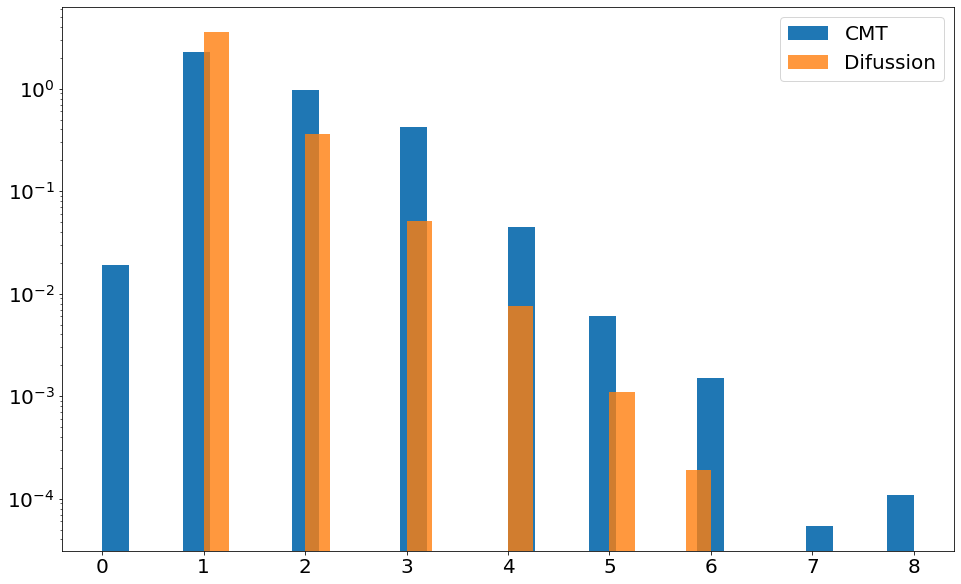

In [78]:
plt.hist(np.round(np.array(E_or)*1000/3.77), bins=30, density=True, label="CMT")
plt.hist(np.round(np.array(E)*1000/3.77), bins=20, density=True, alpha = 0.8, label="Difussion")
plt.legend(loc="best")
plt.yscale("log")
plt.show()

1.1111111111111112
Total Exposure [g*days]:  112.67253333333333


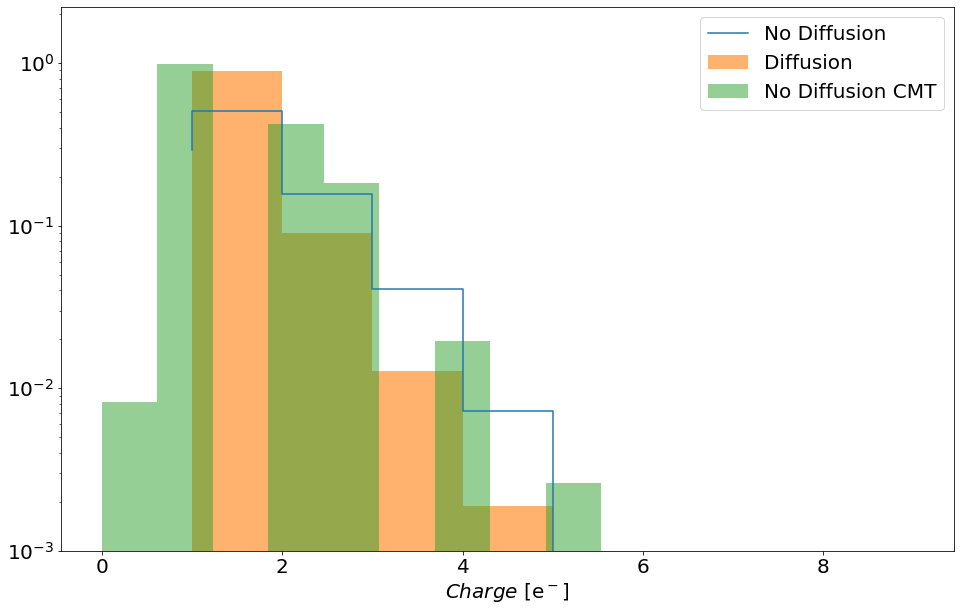

In [46]:
nxbin = 1
nybin = 1
totrows = 1000
totcols = 4000 #6160
nx = 1000
ny = 4000
mass_ccd = 8.8952e-3
n_images = 38
masked_fraction = 0#(2+0.25)/100
exposuremass = n_images*mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  # grams
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 0.001*nx*ny/(3600)
print(tread)
t_exp = 1/3#days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)


nPeaks = 4
n_reps = 1

noise = 0.1
xmin,xmax=-2,10
dm = dm_event.dm_event(10e6,1e-37,0,total_mass,0.3333,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
dm.npix = 1000*4000
dm.normalization_signal()


plt.step(np.arange(len(dm.fs))+1,np.array(dm.fs), label="No Diffusion")

#plt.hist(np.array(E), bins=3, label="Diffusion",alpha = 0.7, density=False)
plt.hist(np.round(np.array(E)*1000/3.77), bins=5, label="Diffusion", density=True, alpha=0.6)
plt.hist(np.round(np.array(E_or)*1000/3.77), bins=13, label="No Diffusion CMT", density=True, alpha =0.5)

plt.yscale("log")
plt.ylim(1e-3,None)
plt.legend(loc="best")
plt.xlabel(r"$Charge$ [e$^-$]")
plt.show()

11


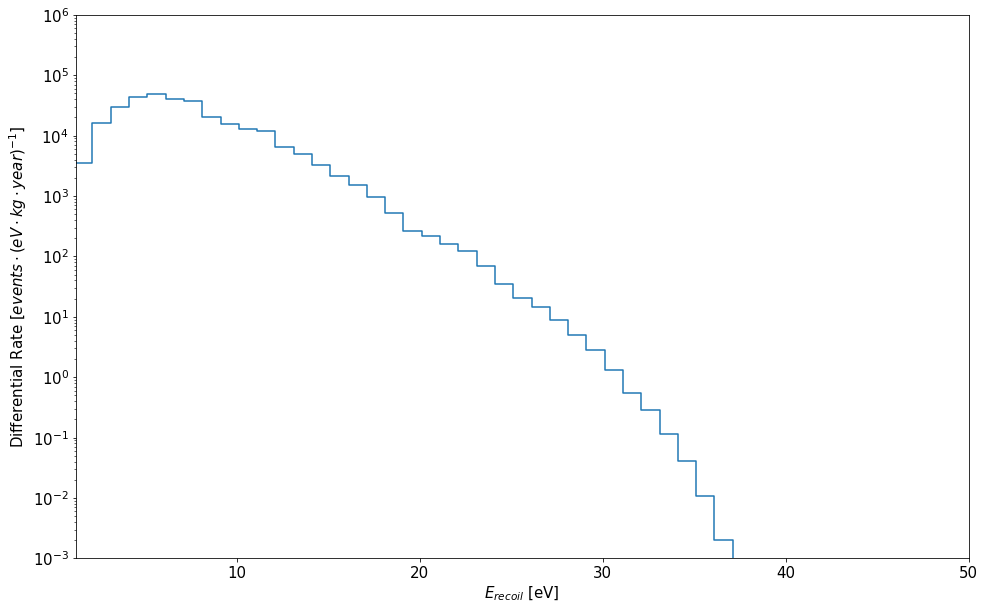

In [8]:
Ei,Ef = 1.2,300
E_bin, dE = 1, 0.1
tmpEbin = int(np.floor(E_bin/dE))+1
print(tmpEbin)
#Ee = np.linspace(Ei,Ef,int((Ef-Ei)/E_bin))
dR = []
xs = 1e-37
"""
for Ei in range(tmpEbin):
    #dR.append(xs*dRdE("Si",10e6,Ei,0,"shm",[230e5,240e5,600e5]))
    dR.append(rate_dme(E_bin,xs,10e6,"Si"))
"""
dR = rate_dme(E_bin,xs,10e6,"Si")
dR_dict = {"energies":dR[0],"rates":dR[1]}
df=pd.DataFrame(dR_dict)
df.to_csv("dR_1e-37_10MeV.csv", index=False)
plt.step(dR[0],dR[1], where="post")
plt.ylim(1e-3, 1e6)
plt.xlim(1.2, 50)
plt.tick_params(labelsize=15)
plt.xlabel(r"$E_{recoil}$ [eV]", fontsize=15)
plt.ylabel(r"Differential Rate $[events\cdot(eV\cdot kg\cdot year)^{-1}]$", fontsize=15)
#plt.xscale("log")
plt.yscale("log")

[2.185462935980142e+39, 4.114171474668374e+39, 1.499690783849456e+39, 4.9101406270916715e+38, 1.1885752841071706e+38, 2.0523334084042839e+37, 5.1783365543738203e+36, 8.648104832780093e+35, 9.20070411593442e+34, 5.216891400055837e+33, 3.133066873224092e+31, 0.0]


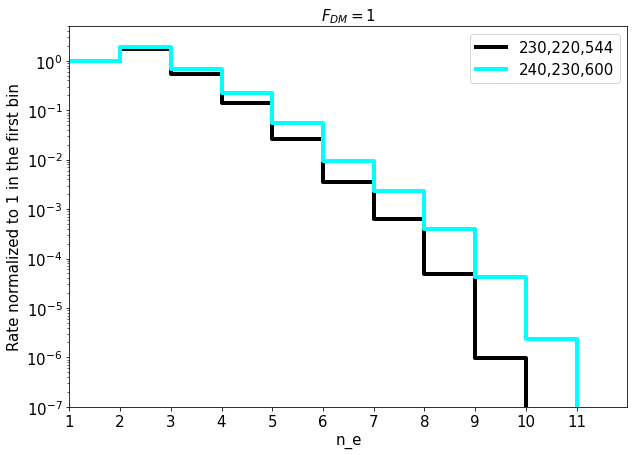

In [25]:
rates_ne_10mev = [dRdne(1, 10e6, ne,0,"shm",[240e5,230e5,600e5]) for ne in range(1, 13)]
rates_ne_1gev = [dRdne(1, 10e6, ne,0,"shm",[230e5,220e5,544e5]) for ne in range(1, 13)]

print(rates_ne_10mev)

rates_normalized_10mev = np.array(rates_ne_10mev)/rates_ne_10mev[0]
rates_normalized_1gev = np.array(rates_ne_1gev)/rates_ne_1gev[0]

plt.figure(figsize=(10, 7))
plt.step(np.arange(0.5, 12.5,1)+0.5, rates_normalized_1gev, where="post", c="black", linewidth=4, label="230,220,544")
plt.step(np.arange(0.5, 12.5,1)+0.5, rates_normalized_10mev, where="post", c="cyan", linewidth=4, label="240,230,600")

plt.ylim(1e-7, 5)
plt.xlim(1, 11.5+0.5)
plt.xticks(range(1, 12))
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.xlabel(r"n_e", fontsize=15)
plt.ylabel(r"Rate normalized to 1 in the first bin", fontsize=15)
#plt.xscale("log")
plt.yscale("log")
plt.title("$F_{DM}=1$", fontsize=15);

[2.132267108329664e+39, 3.6670362245160154e+39, 1.1347408033569601e+39, 3.004986624442277e+38, 5.544372274435313e+37, 7.365558713751796e+36, 1.3246898397464852e+36, 1.0135210659721534e+35, 2.0935047321801123e+33, 0.0, 0.0, 0.0]


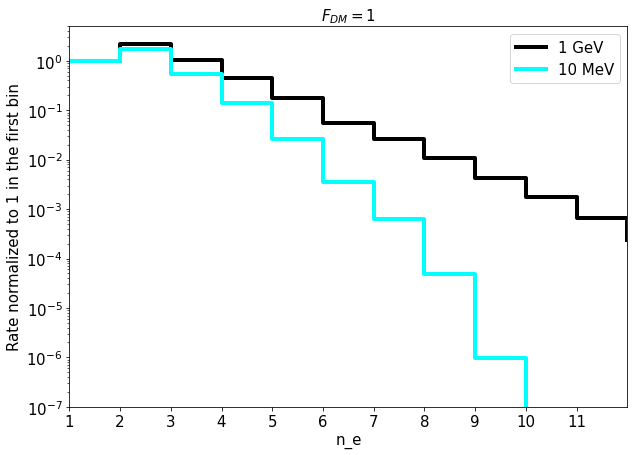

In [27]:
rates_ne_10mev = [dRdne(1, 10e6, ne,0,"shm",[220e5,230e5,544e5]) for ne in range(1, 13)]
rates_ne_1gev = [dRdne(1, 1000e6, ne,0,"shm",[220e5,230e5,544e5]) for ne in range(1, 13)]

print(rates_ne_10mev)

rates_normalized_10mev = np.array(rates_ne_10mev)/rates_ne_10mev[0]
rates_normalized_1gev = np.array(rates_ne_1gev)/rates_ne_1gev[0]

plt.figure(figsize=(10, 7))
plt.step(np.arange(0.5, 12.5,1)+0.5, rates_normalized_1gev, where="post", c="black", linewidth=4, label="1 GeV")
plt.step(np.arange(0.5, 12.5,1)+0.5, rates_normalized_10mev, where="post", c="cyan", linewidth=4, label="10 MeV")

plt.ylim(1e-7, 5)
plt.xlim(1, 11.5+0.5)
plt.xticks(range(1, 12))
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.xlabel(r"n_e", fontsize=15)
plt.ylabel(r"Rate normalized to 1 in the first bin", fontsize=15)
#plt.xscale("log")
plt.yscale("log")
plt.title("$F_{DM}=1$", fontsize=15);

Time Slow:  0.2846487482388814  min
Slow:  6.917141690569948e+41
Time Fast:  8.718172709147136e-05  min
Fast:  7.206947935642215e+41
Time Slow:  0.26847227017084757  min
Slow:  8.874257865689861e+41
Time Fast:  8.504788080851236e-05  min
Fast:  1.0066663268015126e+42
Time Slow:  0.24733502467473348  min
Slow:  1.8206413848311985e+41
Time Fast:  8.218288421630859e-05  min
Fast:  2.342291744921028e+41
Time Slow:  0.2281211296717326  min
Slow:  3.694109505320314e+40
Time Fast:  8.94625981648763e-05  min
Fast:  5.297240018388847e+40
Time Slow:  0.2153250495592753  min
Slow:  6.146296260388813e+39
Time Fast:  9.699662526448567e-05  min
Fast:  9.679989041313483e+39
Time Slow:  0.19562455813090007  min
Slow:  8.016780501164673e+38
Time Fast:  9.17673110961914e-05  min
Fast:  1.3699062544549668e+39
Time Slow:  0.17429958979288737  min
Slow:  1.602537057835257e+38
Time Fast:  9.062687555948893e-05  min
Fast:  2.951600778833652e+38
Time Slow:  0.15326770941416423  min
Slow:  1.996508267760069e+3

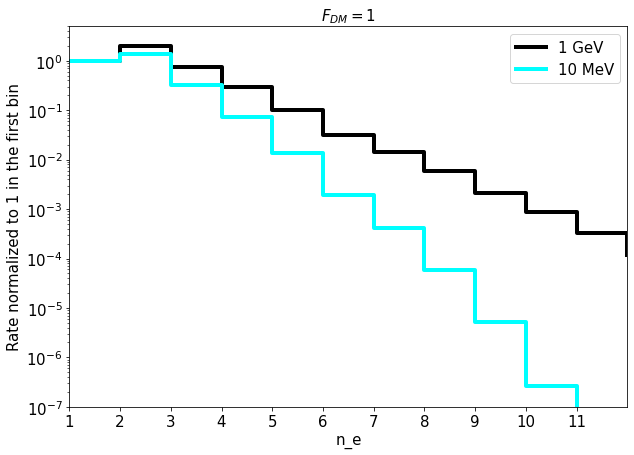

In [3]:
from differential_rate_electronDM import *

rates_ne_10mev = [dRdne(1, 10e6, ne,0,"shm",[220e5,230e5,600e5]) for ne in range(1, 13)]
rates_ne_1gev = [dRdne(1, 1000e6, ne,0,"shm",[220e5,230e5,600e5]) for ne in range(1, 13)]

print(rates_ne_10mev)

rates_normalized_10mev = np.array(rates_ne_10mev)/rates_ne_10mev[0]
rates_normalized_1gev = np.array(rates_ne_1gev)/rates_ne_1gev[0]

plt.figure(figsize=(10, 7))
plt.step(np.arange(0.5, 12.5,1)+0.5, rates_normalized_1gev, where="post", c="black", linewidth=4, label="1 GeV")
plt.step(np.arange(0.5, 12.5,1)+0.5, rates_normalized_10mev, where="post", c="cyan", linewidth=4, label="10 MeV")

plt.ylim(1e-7, 5)
plt.xlim(1, 11.5+0.5)
plt.xticks(range(1, 12))
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.xlabel(r"n_e", fontsize=15)
plt.ylabel(r"Rate normalized to 1 in the first bin", fontsize=15)
#plt.xscale("log")
plt.yscale("log")
plt.title("$F_{DM}=1$", fontsize=15);

In [ ]:
nxbin = 1
nybin = 10
totrows = 6144
totcols = 4128 #6160
nx = 636
ny = 840
mass_ccd = 8.8952e-3
n_images = 38
masked_fraction = 0#(2+0.25)/100
exposuremass = n_images*mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  # grams
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 22583.2/86400*24
print(tread)
t_exp = tread/24 #days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)
xmin, xmax = -10,10
xs_35 = []
mass_x = np.geomspace(0.6, 100, 40)*1e6

### CCD 1
#noise = 1.628
#print(8.2/t_exp+2.8)
#dc = (8.2/t_exp+2.8)*(15*15)*1e-6
#mu0 = 0#-0.185

### CCD 3
noise = 1.572
print(t_exp)
dcmm2days = (7.8/t_exp+1.7)+20
dc = dcmm2days*(15*15)*1e-6
mu0 = -0.160

lam = dc*t_exp*nxbin*nybin
print("Dark Current [e/pix*days]: ", dc)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*days]: ", dc*nxbin*nybin)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*img]: ", lam)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/mm2*img]: ", dcmm2days*t_exp)#*1e8/(15**2*6.28*1e18*24*3600))

#df_inf = pd.read_csv("DAMICM_Upper.csv", comment="#")
#mass_x = df_inf["mx"]

nPeaks = 4
n_reps = 1
xs_0 = np.zeros([len(mass_x),n_reps])
xs_1 = np.zeros([len(mass_x),n_reps])
xs_2 = np.zeros([len(mass_x),n_reps])

df = pd.read_csv("cumulativePCD_7x7x50x150_amp_L_v1.csv", header=None)
events = df[0]
npix = len(events)
texp=22583.2/86400 #days
mass_det = npix*3.507e-9 #kg
print("{} g*days".format(mass_det*texp*1000))
print(npix)



for i,m in enumerate(mass_x):
    print("------Mass {} MeV-------".format(m*1e-6))
    for j in range(n_reps):
        dm = dm_event.dm_event(m,1e-33,0,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        #dm.npix = int(3.2e6)
        low_cross = np.log10(dm.lowest_cross_section)-4
        
        dm.events = events
        dm.npix = npix
        dm.texp = texp #days
        dm.mass_det = mass_det
        dm.normalization_signal()
        
        dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-2,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks, bin_size=0.1)
        #print(dm.cross_section_dLL)
        xs_0[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,1,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        
        dm.events = events
        dm.npix = npix
        dm.texp = texp #days
        dm.mass_det = mass_det        
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_1[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,2,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        
        dm.events = events
        dm.npix = npix
        dm.texp = texp #days
        dm.mass_det = mass_det
        
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_2[i][j] = dm.cross_section_dLL

        """
        plt.hist(dm.events, bins = 10, density = False)
        dm = dm_event.dm_event(14, 14, m, dm.cross_section_95, 0.6, 1, True, Eemin=0.06, Eemax=Eemax, eff="efficiency_DAMIC.csv")
        dm.plot_var("dRdE")
        plt.loglog()
        plt.xlim(0.06,1)
        plt.ylim(1e-3,1e2)
        plt.show()
        """
        
    df_inf = pd.read_csv("DAMICSNOLAB_q0.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="r", label=r"Paper Limit $q=0$", linewidth=4,alpha=0.6)
    
            
    df_inf = pd.read_csv("DAMICSNOLAB_q1.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="b", label=r"Paper Limit $q=1$", linewidth=4,alpha=0.6)
    
                
    df_inf = pd.read_csv("DAMICSNOLAB_q2.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="k", label=r"Paper Limit $q=2$", linewidth=4, alpha=0.6)
    
    
    #df_sup = pd.read_csv("DAMICS_sup.csv", comment="#")
    #x2,y2 = df_sup["mx"],df_sup["xs"]

    #plt.plot(x1,y1, 'o',label="DAMICM Upper Limit Papers")
    #plt.fill(
    #    np.append(x1, x2[::-1]),
    #    np.append(y1, y2[::-1]), color="r", alpha = 0.6, label="DAMIC Paper"
    #)

    xs_mean = np.median(xs_0, axis=1)
    xs_std = np.std(xs_0, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "r")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=0", alpha = 0.4, color = "r")

    xs_mean = np.median(xs_1, axis=1)
    xs_std = np.std(xs_1, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "b")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=1", alpha = 0.4, color = "b")

 
    xs_mean = np.median(xs_2, axis=1)
    xs_std = np.std(xs_2, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "k")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=2", alpha = 0.4, color = "k")

 
    
    plt.xlabel(r"Dark Matter Mass [MeV]")
    plt.ylabel(r"Dark Matter-e$^-$ $\sigma$ [cm$^2$]")
    plt.title("DAMIC-SNOLAB Upper Limits on Cross Section")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-36,1e-27)
    plt.xlim(0.5,100)
    #plt.xticks([1,5,10], [1,5,10])
    #plt.yticks([10**i for i in range(-44,-34)], [r"$10^{"+str(i)+"}$" for i in range(-44,-34)])
    plt.grid(True, 'both')
    plt.legend(loc="best")
    plt.show()

6.2731111111111115
Total Exposure [g*days]:  1.8610436444362013
0.26137962962962963
Dark Current [e/pix*days]:  0.011596871745368236
Dark Current [e/pix_binned*days]:  0.11596871745368235
Dark Current [e/pix_binned*img]:  0.030311860416666662
Dark Current [e/mm2*img]:  13.471937962962961
39.71121593905608 g*days
43321719
------Mass 0.6 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  39.71121593905608
Number of Total Pixels:  43321719
Number of Signal events:  7


# Upper limit SI

In [3]:
nxbin = 1
nybin = 1
totrows = 6144
totcols = 4128 #6160
nx = 636
ny = 840
mass_ccd = 8.8952e-3
n_images = 60
masked_fraction = 0.08#(2+0.25)/100
exposuremass = n_images*mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  # grams
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 1e5/(3600)
print(tread)
t_exp = tread/24 #days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)
xmin, xmax = -10,10
xs_35 = []
mass_x = np.geomspace(0.6, 100, 10)*1e6

### CCD 1
#noise = 1.628
#print(8.2/t_exp+2.8)
#dc = (8.2/t_exp+2.8)*(15*15)*1e-6
#mu0 = 0#-0.185

### CCD 3
noise = 2.08/9.978
print(t_exp)
dc = 0.00107
mu0 = 0

lam = dc*t_exp*nxbin*nybin
"""
print("Dark Current [e/pix*days]: ", dc)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*days]: ", dc*nxbin*nybin)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*img]: ", lam)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/mm2*img]: ", dcmm2days*t_exp)#*1e8/(15**2*6.28*1e18*24*3600))
"""
#df_inf = pd.read_csv("DAMICM_Upper.csv", comment="#")
#mass_x = df_inf["mx"]

nPeaks = 3
n_reps = 1
xs_0 = np.zeros([len(mass_x),n_reps])
xs_1 = np.zeros([len(mass_x),n_reps])
xs_2 = np.zeros([len(mass_x),n_reps])

for i,m in enumerate(mass_x):
    print("------Mass {} MeV-------".format(m*1e-6))
    for j in range(n_reps):
        dm = dm_event.dm_event(m,1e-33,0,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        #dm.npix = int(3.2e6)
        low_cross = np.log10(dm.lowest_cross_section)-4
        dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(mu0-1e-3,mu0+1e-3),(noise-1e-3,noise+1e-3),(0.8,1.2),(1e-4,1e0),(low_cross-1,-26)], 
                      verbose=True, simulate=[mu0,noise,lam], upper_limit=[0.9,True],nPeaks=nPeaks)#, nPeaks=nPeaks, bin_size=0.1)
        #print(dm.cross_section_dLL)
        xs_0[i][j] = dm.cross_section_dLL
        
        
    df_inf = pd.read_csv("LBC_median.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="r", label=r"Jean Philippe", linewidth=4,alpha=0.6)
    

    xs_mean = np.median(xs_0, axis=1)
    xs_std = np.std(xs_0, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "r")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=0", alpha = 0.4, color = "r")
 
    
    plt.xlabel(r"Dark Matter Mass [MeV]")
    plt.ylabel(r"Dark Matter-e$^-$ $\sigma$ [cm$^2$]")
    plt.title("DAMIC-SNOLAB Upper Limits on Cross Section")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-38,1e-30)
    plt.xlim(0.5,100)
    #plt.xticks([1,5,10], [1,5,10])
    #plt.yticks([10**i for i in range(-44,-34)], [r"$10^{"+str(i)+"}$" for i in range(-44,-34)])
    plt.grid(True, 'both')
    plt.legend(loc="best")
    plt.show()

27.77777777777778
Total Exposure [g*days]:  11.970893264494512
1.1574074074074074
------Mass 0.6 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  11.970893264494512
Number of Total Pixels:  29490048
Number of Signal events:  1


KeyboardInterrupt: 

27.77777777777778
Total Exposure [g*days]:  156.67601365943204
1.1574074074074074
------Mass 0.6 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  17


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


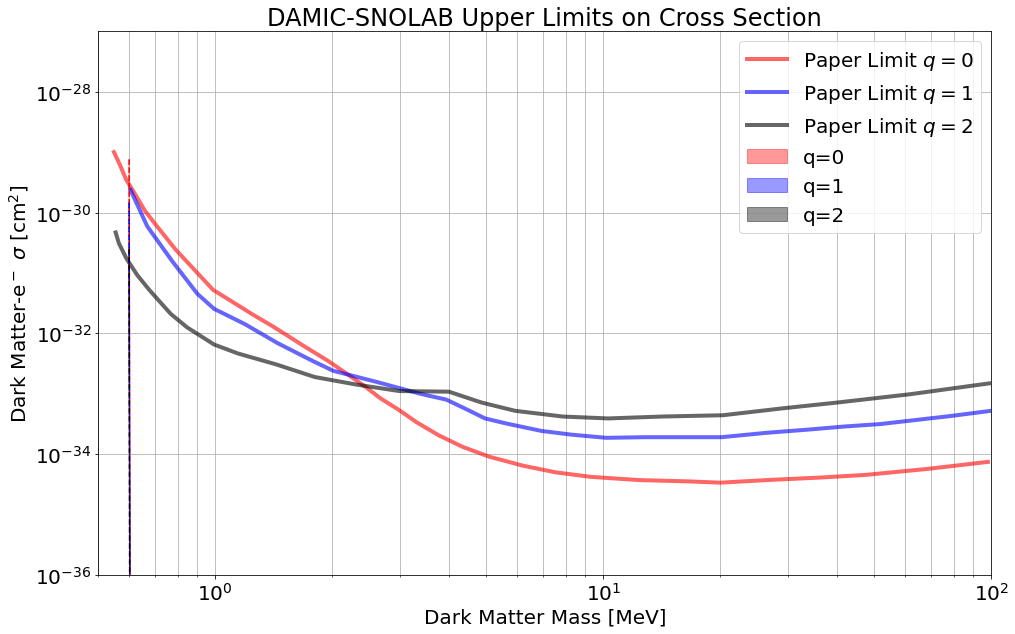

------Mass 1.0593106380474595 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  7342


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


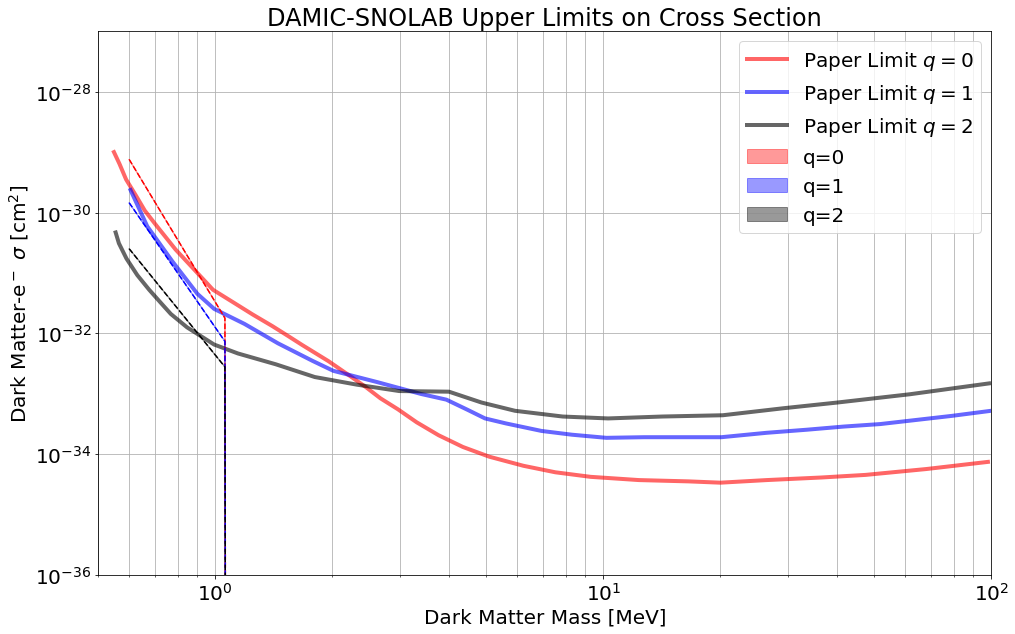

------Mass 1.8702317131341932 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  147776


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


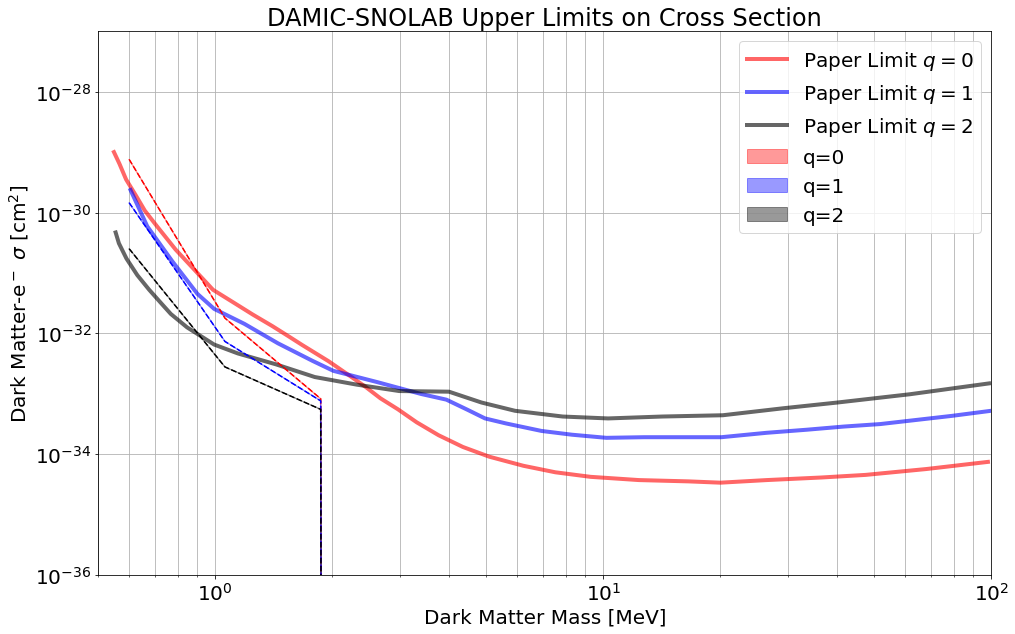

------Mass 3.3019272488946263 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  748471


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


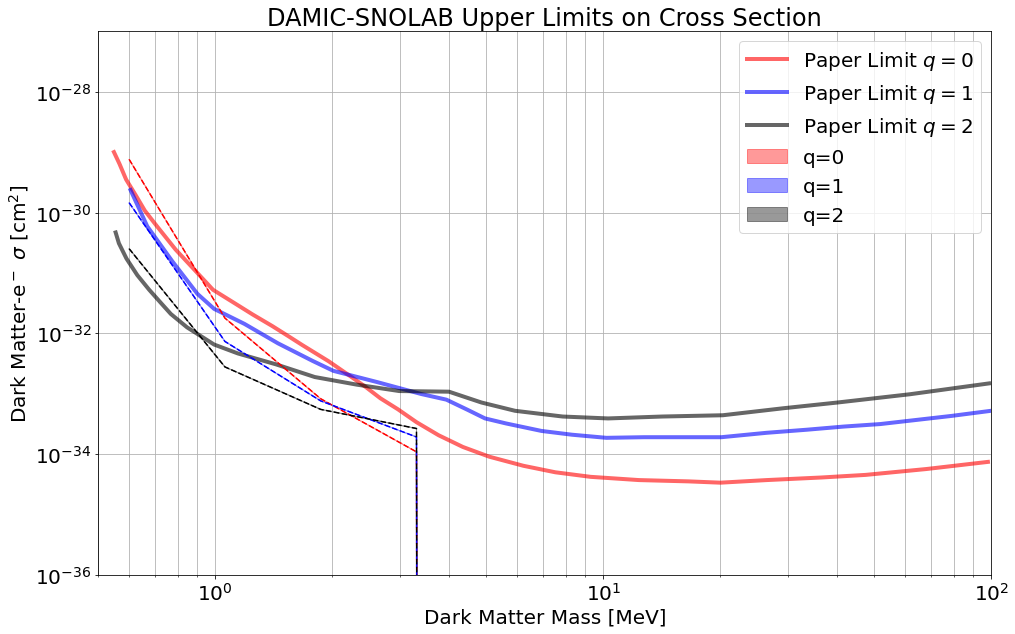

------Mass 5.829611101354765 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  1208137


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


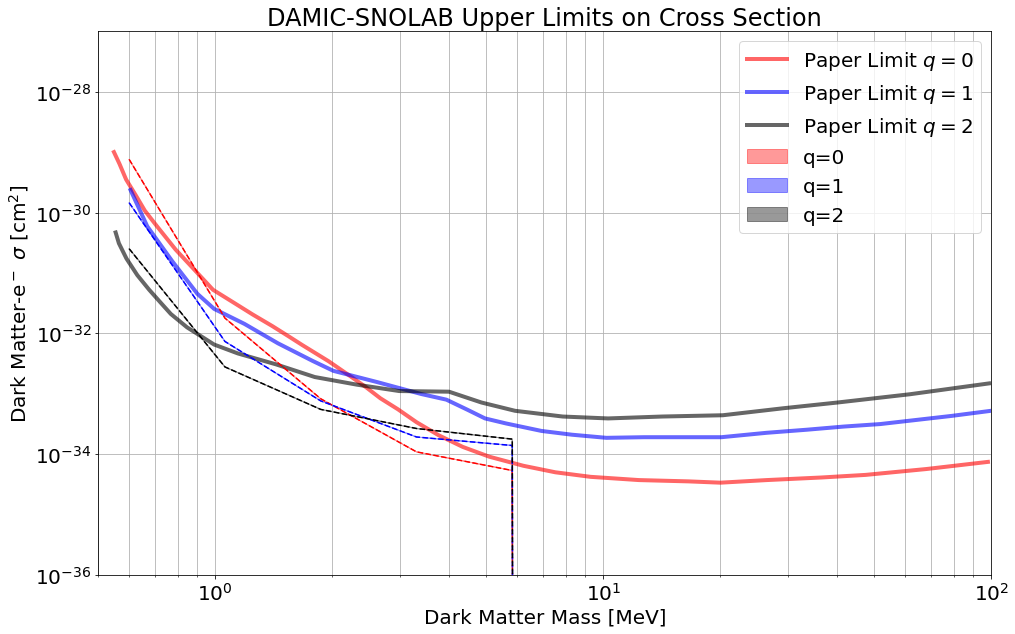

------Mass 10.292281758907782 MeV-------
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  1143943


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


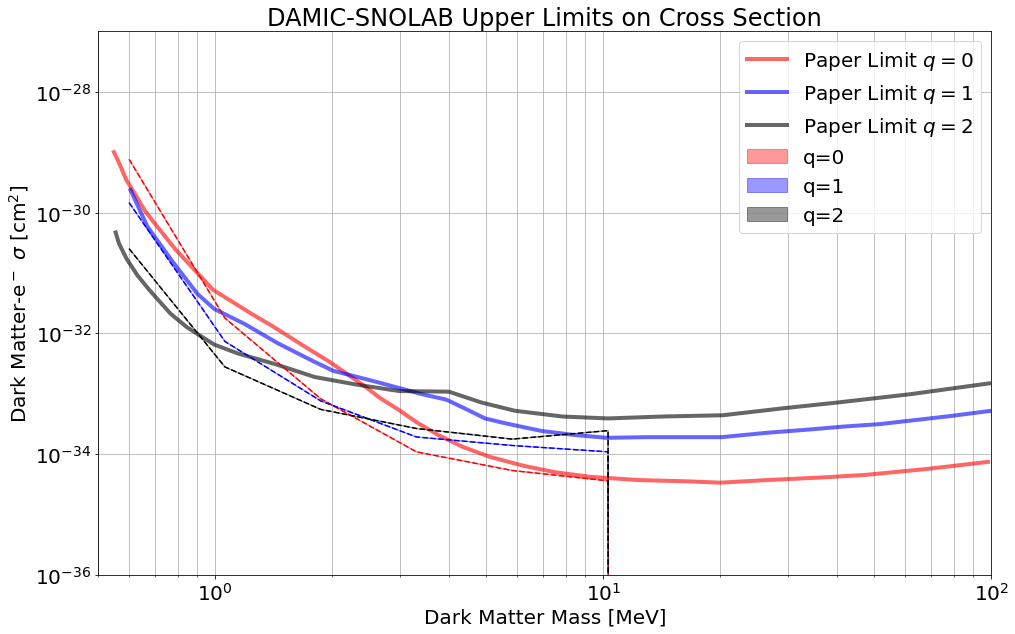

------Mass 18.171205928321392 MeV-------
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  845579
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


14 1.778279410038923e-33
$n_e$ is out of range, pick a smaller value
14 1.333521432163324e-34
$n_e$ is out of range, pick a smaller value
14 3.651741272548377e-35
$n_e$ is out of range, pick a smaller value
14 6.978305848598663e-35
$n_e$ is out of range, pick a smaller value
14 5.048065716667471e-35
$n_e$ is out of range, pick a smaller value
14 4.293510210083482e-35
$n_e$ is out of range, pick a smaller value
14 4.6555259311579585e-35
$n_e$ is out of range, pick a smaller value
14 4.470855412416633e-35
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value
14 1.77

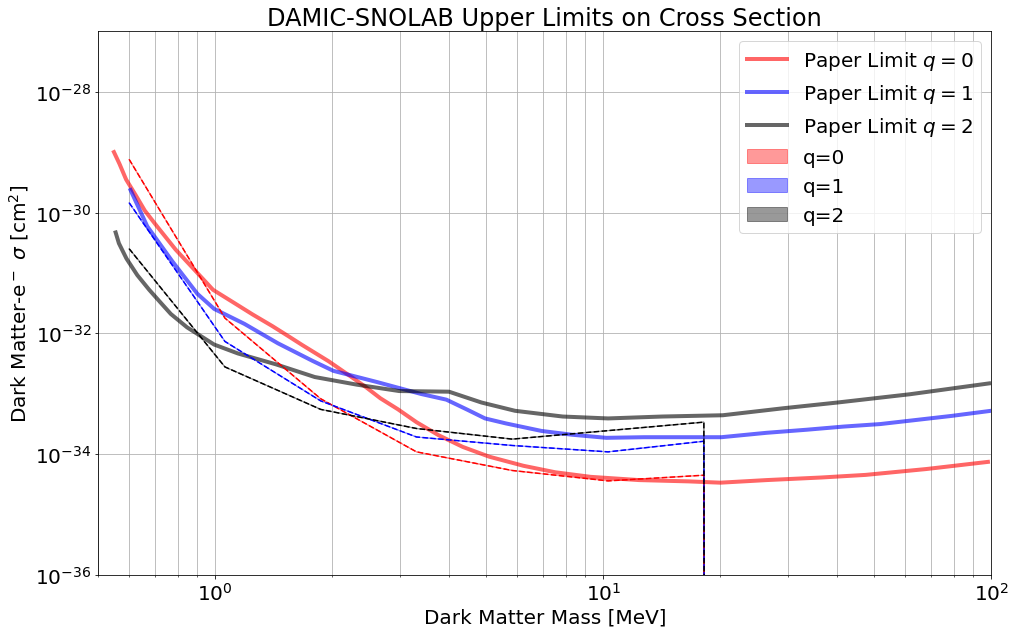

------Mass 32.08158624336984 MeV-------
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  552095
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


14 1.778279410038923e-33
$n_e$ is out of range, pick a smaller value
14 1.333521432163324e-34
$n_e$ is out of range, pick a smaller value
14 3.651741272548377e-35
$n_e$ is out of range, pick a smaller value
14 6.978305848598663e-35
$n_e$ is out of range, pick a smaller value
14 5.048065716667471e-35
$n_e$ is out of range, pick a smaller value
14 5.935229272296986e-35
$n_e$ is out of range, pick a smaller value
14 6.435669750977287e-35
$n_e$ is out of range, pick a smaller value
14 6.180386354657502e-35
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value
14 1.778

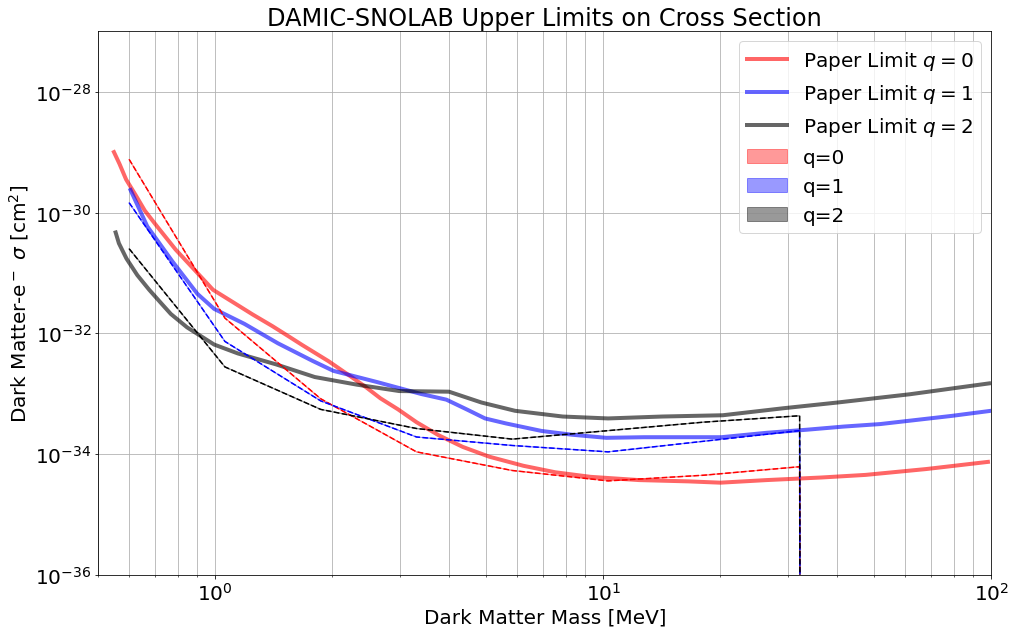

------Mass 56.64060932173119 MeV-------
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  338756
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


14 1.778279410038923e-33
$n_e$ is out of range, pick a smaller value
14 1.333521432163324e-34
$n_e$ is out of range, pick a smaller value
14 3.651741272548377e-35
$n_e$ is out of range, pick a smaller value
14 6.978305848598663e-35
$n_e$ is out of range, pick a smaller value
14 9.646616199111992e-35
$n_e$ is out of range, pick a smaller value
14 1.1341944035027569e-34
$n_e$ is out of range, pick a smaller value
14 1.0459989534302536e-34
$n_e$ is out of range, pick a smaller value
14 1.0045073642544624e-34
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value
14 1.

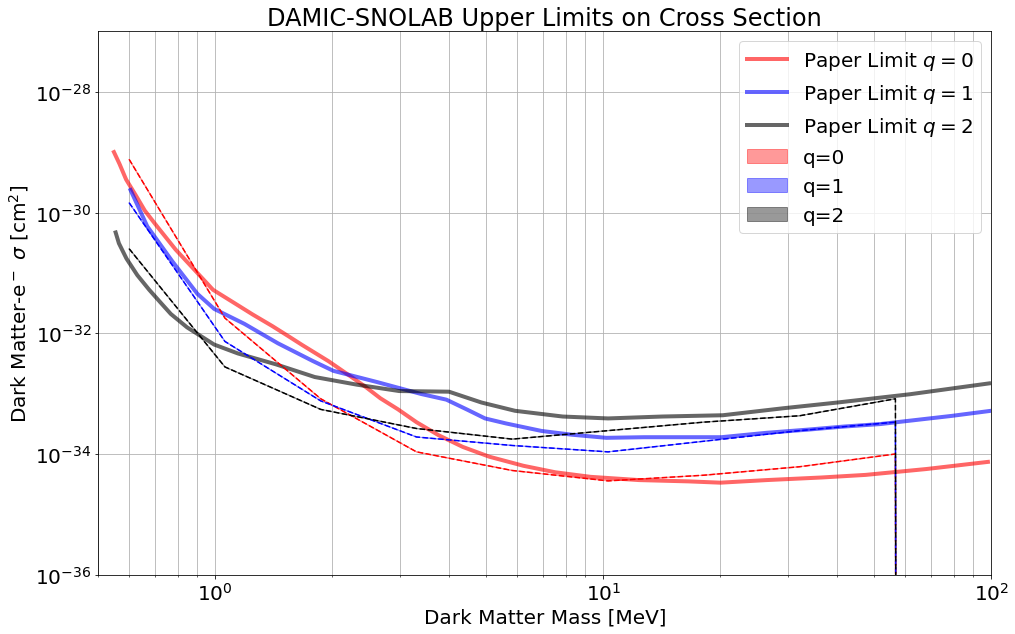

------Mass 100.0 MeV-------
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
------------ Using Si model -----------
Exposure [g*days]:  156.67601365943204
Number of Total Pixels:  3822220
Number of Signal events:  200399
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value


/home/alantero/repositories/DAMIC_DMe/dm_event.py:307: RuntimeWarning: invalid value encountered in log
  LL = n_data*np.log(n_theo)-n_theo+n_data-n_data*np.log(n_data)-0.5*np.log(2*np.pi*n_data)


14 1.778279410038923e-33
$n_e$ is out of range, pick a smaller value
14 1.333521432163324e-34
$n_e$ is out of range, pick a smaller value
14 4.869675251658631e-34
$n_e$ is out of range, pick a smaller value
14 2.5482967479793464e-34
$n_e$ is out of range, pick a smaller value
14 1.8434229924091104e-34
$n_e$ is out of range, pick a smaller value
14 1.5678788438269704e-34
$n_e$ is out of range, pick a smaller value
14 1.4459599030674115e-34
$n_e$ is out of range, pick a smaller value
14 1.3886030825218544e-34
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-34
$n_e$ is out of range, pick a smaller value
14 1e-36
$n_e$ is out of range, pick a smaller value
14 1e-39
$n_e$ is out of range, pick a smaller value
14 1e-33
$n_e$ is out of range, pick a smaller value
14 1e-26
$n_e$ is out of range, pick a smaller value
14 1e-35
$n_e$ is out of range, pick a smaller value
14 3.162277660168379e-31
$n_e$ is out of range, pick a smaller value
14 

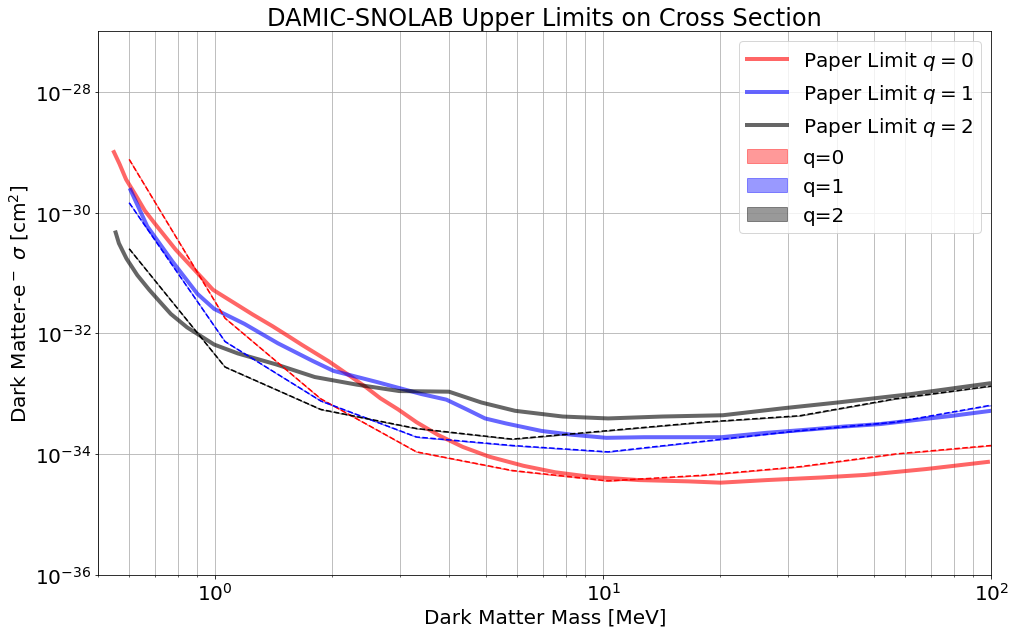

In [4]:
nxbin = 1
nybin = 100
totrows = 4116
totcols = 4116 #6160
nx = 2500and + or python
ny = 4116
mass_ccd = 6e-3
n_images = 38
masked_fraction = (2+0.25)/100
exposuremass = n_images*mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  # grams
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 1e5/(3600)
print(tread)
t_exp = tread/24 #days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)
xmin, xmax = -10,10
xs_35 = []
mass_x = np.geomspace(0.6, 100, 10)*1e6

### CCD 1
#noise = 1.628
#print(8.2/t_exp+2.8)
#dc = (8.2/t_exp+2.8)*(15*15)*1e-6
#mu0 = 0#-0.185

### CCD 3
noise = 1.572
print(t_exp)
#dcmm2days = (7.8/t_exp+1.7)+20
#dc = dcmm2days*(15*15)*1e-6
dc = (7.8+1.7*t_exp)*(15*15)*1e-6*4#*nxbin*nybin
mu0 = -0.160

lam = dc*t_exp*nxbin*nybin
"""
print("Dark Current [e/pix*days]: ", dc)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*days]: ", dc*nxbin*nybin)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*img]: ", lam)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/mm2*img]: ", dcmm2days*t_exp)#*1e8/(15**2*6.28*1e18*24*3600))
"""
#df_inf = pd.read_csv("DAMICM_Upper.csv", comment="#")
#mass_x = df_inf["mx"]

nPeaks = 4
n_reps = 1
xs_0 = np.zeros([len(mass_x),n_reps])
xs_1 = np.zeros([len(mass_x),n_reps])
xs_2 = np.zeros([len(mass_x),n_reps])

for i,m in enumerate(mass_x):
    print("------Mass {} MeV-------".format(m*1e-6))
    for j in range(n_reps):
        dm = dm_event.dm_event(m,1e-33,0,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        #dm.npix = int(3.2e6)
        low_cross = np.log10(dm.lowest_cross_section)-4
        dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(mu0-1e-3,mu0+1e-3),(noise-1e-3,noise+1e-3),(0.8,1.2),(1e-2,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks, bin_size=0.1)
        #print(dm.cross_section_dLL)
        xs_0[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,1,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(mu0-1e-3,mu0+1e-3),(noise-1e-3,noise+1e-3),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #dm.verbose()

        #print(dm.cross_section_dLL)
        xs_1[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,2,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(mu0-1e-3,mu0+1e-3),(noise-1e-3,noise+1e-3),(0.8,1.2),(1e-3,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_2[i][j] = dm.cross_section_dLL

        """
        plt.hist(dm.events, bins = 10, density = False)
        dm = dm_event.dm_event(14, 14, m, dm.cross_section_95, 0.6, 1, True, Eemin=0.06, Eemax=Eemax, eff="efficiency_DAMIC.csv")
        dm.plot_var("dRdE")
        plt.loglog()
        plt.xlim(0.06,1)
        plt.ylim(1e-3,1e2)
        plt.show()
        """
        
    df_inf = pd.read_csv("DAMICSNOLAB_q0.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="r", label=r"Paper Limit $q=0$", linewidth=4,alpha=0.6)
    
    
            
    df_inf = pd.read_csv("DAMICSNOLAB_q1.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="b", label=r"Paper Limit $q=1$", linewidth=4,alpha=0.6)
    
                
    df_inf = pd.read_csv("DAMICSNOLAB_q2.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="k", label=r"Paper Limit $q=2$", linewidth=4, alpha=0.6)
    
    
    #df_sup = pd.read_csv("DAMICS_sup.csv", comment="#")
    #x2,y2 = df_sup["mx"],df_sup["xs"]

    #plt.plot(x1,y1, 'o',label="DAMICM Upper Limit Papers")
    #plt.fill(
    #    np.append(x1, x2[::-1]),
    #    np.append(y1, y2[::-1]), color="r", alpha = 0.6, label="DAMIC Paper"
    #)

    xs_mean = np.median(xs_0, axis=1)
    xs_std = np.std(xs_0, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "r")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=0", alpha = 0.4, color = "r")

    xs_mean = np.median(xs_1, axis=1)
    xs_std = np.std(xs_1, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "b")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=1", alpha = 0.4, color = "b")

 
    xs_mean = np.median(xs_2, axis=1)
    xs_std = np.std(xs_2, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "k")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=2", alpha = 0.4, color = "k")
 
    
    plt.xlabel(r"Dark Matter Mass [MeV]")
    plt.ylabel(r"Dark Matter-e$^-$ $\sigma$ [cm$^2$]")
    plt.title("DAMIC-SNOLAB Upper Limits on Cross Section")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-36,1e-27)
    plt.xlim(0.5,100)
    #plt.xticks([1,5,10], [1,5,10])
    #plt.yticks([10**i for i in range(-44,-34)], [r"$10^{"+str(i)+"}$" for i in range(-44,-34)])
    plt.grid(True, 'both')
    plt.legend(loc="best")
    plt.show()

In [ ]:
nxbin = 1
nybin = 10
totrows = 3072*4
totcols = 443*4 #6160
nx = 443
ny = 3072
mass_ccd = 1.926e-3
masked_fraction = (1-(nx-93)/nx)+0.069#(2+0.25)/100
exposuremass = mass_ccd*(nx*ny)/(totrows*totcols)*(1-masked_fraction)  
n_images = int(19.93e-3/(exposuremass*20/24))
print("Number Images: ", n_images)
exposuremass = n_images*exposuremass
print(n_images*nx*ny*(1-masked_fraction))
#exposuremass = 0.1500
#exposuretime = 23400/(60*60*24)  # seconds == 5*1.3h*3600s/h

nccd = 1
total_mass = nccd*exposuremass


#tread = 8.3*100/30 #hours
tread = 20 #+ 5.153#1e5/(3600)
print(tread)
t_exp = tread/24 #days
print("Total Exposure [g*days]: ", total_mass*1e3*t_exp)
xmin, xmax = -10,10
xs_35 = []
mass_x = np.geomspace(0.6, 100, 10)*1e6

### CCD 1
#noise = 1.628
#print(8.2/t_exp+2.8)
#dc = (8.2/t_exp+2.8)*(15*15)*1e-6
#mu0 = 0#-0.185

### Quadrant 1
noise = 0.146
print(t_exp)
dcimg = 1.067e-3#dcmm2days*(15*15)*1e-6
dc = dcimg/t_exp
mu0 = 0

lam = dc*t_exp*nxbin*nybin
print("Dark Current [e/pix*days]: ", dc)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*days]: ", dc*nxbin*nybin)#*1e8/(15**2*6.28*1e18*24*3600))
print("Dark Current [e/pix_binned*img]: ", lam)#*1e8/(15**2*6.28*1e18*24*3600))
#print("Dark Current [e/mm2*img]: ", dcmm2days*t_exp)#*1e8/(15**2*6.28*1e18*24*3600))

#df_inf = pd.read_csv("DAMICM_Upper.csv", comment="#")
#mass_x = df_inf["mx"]

nPeaks = 4
n_reps = 1
xs_0 = np.zeros([len(mass_x),n_reps])
xs_1 = np.zeros([len(mass_x),n_reps])
xs_2 = np.zeros([len(mass_x),n_reps])

for i,m in enumerate(mass_x):
    for j in range(n_reps):
        print("------Mass {} GeV-------".format(m))
        dm = dm_event.dm_event(m,1e-33,0,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        #dm.npix = int(3.2e6)
        low_cross = np.log10(dm.lowest_cross_section)-4
        dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-4,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks, bin_size=0.1)
        #print(dm.cross_section_dLL)
        xs_0[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,1,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-4,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_1[i][j] = dm.cross_section_dLL
        
        
        dm = dm_event.dm_event(m,1e-33,2,total_mass,t_exp,noise, xmin=xmin, xmax=xmax,ccd_mass=mass_ccd,
                              tread=tread, nccd=nccd,nx=nx,ny=ny,nxbin=nxbin,nybin=nybin,
                              n_image=n_images, mask_frac=masked_fraction)
        low_cross = np.log10(dm.lowest_cross_section)-4
        #dm.verbose()
        dm.likelihood(x0=[dm.npix,mu0,noise,1,lam,low_cross],fix_pars=[0,1,2,3],
                      pars_lims=[(1e4,1e10),(-0.3,0.3),(0.07,2.5),(0.8,1.2),(1e-4,1e0),(low_cross-1,-26)], 
                      verbose=False, simulate=[mu0,noise,lam], upper_limit=[0.9,True])#, nPeaks=nPeaks)
        #print(dm.cross_section_dLL)
        xs_2[i][j] = dm.cross_section_dLL

        """
        plt.hist(dm.events, bins = 10, density = False)
        dm = dm_event.dm_event(14, 14, m, dm.cross_section_95, 0.6, 1, True, Eemin=0.06, Eemax=Eemax, eff="efficiency_DAMIC.csv")
        dm.plot_var("dRdE")
        plt.loglog()
        plt.xlim(0.06,1)
        plt.ylim(1e-3,1e2)
        plt.show()
        """
        
    df_inf = pd.read_csv("DAMICSNOLAB_q0.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="r", label=r"Paper Limit $q=0$", linewidth=4,alpha=0.6)
    
    
            
    df_inf = pd.read_csv("DAMICSNOLAB_q1.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="b", label=r"Paper Limit $q=1$", linewidth=4,alpha=0.6)
    
                
    df_inf = pd.read_csv("DAMICSNOLAB_q2.csv", comment="#")
    df_inf["mx"]
    x1,y1 = df_inf["mx"],df_inf["xs"]
    plt.plot(x1,y1, color="k", label=r"Paper Limit $q=2$", linewidth=4, alpha=0.6)
    
    
    #df_sup = pd.read_csv("DAMICS_sup.csv", comment="#")
    #x2,y2 = df_sup["mx"],df_sup["xs"]

    #plt.plot(x1,y1, 'o',label="DAMICM Upper Limit Papers")
    #plt.fill(
    #    np.append(x1, x2[::-1]),
    #    np.append(y1, y2[::-1]), color="r", alpha = 0.6, label="DAMIC Paper"
    #)

    xs_mean = np.median(xs_0, axis=1)
    xs_std = np.std(xs_0, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "r")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=0", alpha = 0.4, color = "r")

    xs_mean = np.median(xs_1, axis=1)
    xs_std = np.std(xs_1, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "b")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=1", alpha = 0.4, color = "b")

 
    xs_mean = np.median(xs_2, axis=1)
    xs_std = np.std(xs_2, axis=1)
    plt.plot(mass_x*1e-6,xs_mean,'--', color = "k")
    plt.fill_between(mass_x*1e-6,xs_mean-xs_std,(xs_mean+xs_std), label=r"q=2", alpha = 0.4, color = "k")

 
    
    plt.xlabel(r"Dark Matter Mass [MeV]")
    plt.ylabel(r"Dark Matter-e$^-$ $\sigma$ [cm$^2$]")
    plt.title("DAMIC-SNOLAB Upper Limits on Cross Section")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-36,1e-27)
    plt.xlim(0.5,100)
    #plt.xticks([1,5,10], [1,5,10])
    #plt.yticks([10**i for i in range(-44,-34)], [r"$10^{"+str(i)+"}$" for i in range(-44,-34)])
    plt.grid(True, 'both')
    plt.legend(loc="best")
    plt.show()

Number Images:  275
269856998.40000004
20
Total Exposure [g*days]:  19.891329059678334
0.8333333333333334
Dark Current [e/pix*days]:  0.0012804
Dark Current [e/pix_binned*days]:  0.012804
Dark Current [e/pix_binned*img]:  0.01067
------Mass 600000.0 GeV-------
Lowest Cross Section:  1e-33
------------ Using Si model -----------
Exposure [g*days]:  19.891329059678334
Number of Total Pixels:  26985700
Number of Signal events:  0
Lamb:  0.01067
Cross 90CF:  -29.7734375
Lowest Cross Section:  1e-34
Lamb:  0.01067
Cross 90CF:  -30.494140625
Lowest Cross Section:  1e-36
Lamb:  0.01067


In [9]:
from scipy.stats import chi2

chi2.ppf(0.9,df=1)/2

1.352771727047702